# Home assignment - Artlist - Deep Learning
## Background
Artlist has a vast catalog of music, sfx, footage and more.
In this task we will build a small sematic search engine for footage.
In order to simplify this task, we'll work with thumbnail and not full videos.


### Goal
My Goal is to build a semantic search engine for footage, which utilize embeddings - and later evaluate it.




### Data

The dataset contains 61 thumbnails.
The filenames are not meaningful.
All files are shared with you in Google drive




# Part 1 - embedding the data
Deep learning model are able to extract valuable information from images.
There are several strategies that can be applied, choose one or two and implement those.

Example options:
* Text to text embeddings - extract description using an image captioning [model](https://github.com/salesforce/LAVIS?tab=readme-ov-file#image-captioning) and extract textual embeddings from one of the popular [text embeddings models](https://huggingface.co/spaces/mteb/leaderboard).
* Use a multimodal model such as CLIP. you can see [different varients here](https://github.com/mlfoundations/open_clip/blob/main/docs/openclip_retrieval_results.csv) most of them are available through hugging face.

Feel free to choose the implemention/model/strategy you feel is right for this task


### Init

In [1]:
%load_ext autoreload
%autoreload 2 
from PIL import Image
import os
import utils
import pandas as pd
import chromadb
from matplotlib import pyplot as plt

/Users/yonierlich/Documents/repos/arlist/my_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Get the images path 

In [2]:
image_folder = 'dataset'
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.png')]
images = utils.load_images(image_paths)

### Load the model and embed the images

I choose to do the embedding via a multimodel, specificaly -  CLIP model. The reasons are:
-  It directly align the text and the images into a joint embedding space - therfore provide a more accurate embedding.
-  Simple of use - single model for both text and images

Cons: 
- relative to Image Captioning + Text Embeddings, the  text descriptions may be not as rich and contact senstive  - due to "static embeddings" vs "dynamic embeddings"

In [3]:
model_name = 'openai/clip-vit-base-patch32'
embeding_func = utils.CLIPEmbeddingFunction(model_name)
image_embeddings = embeding_func.embed_images(images)

# Part 2 - Search engine

In order to use semantic search, you need a way to search through embeddings. as well as other functionalities - depends on your use case.

Choose one engine (below are some suggested options) and feed the embeddings.

Write a function to perform search. you can add more functionality if you feel it needed.

Vector search:
* [scaNN](https://github.com/google-research/google-research/tree/master/scann)
* [ChromaDB](https://www.trychroma.com/)
* [Qdrant](https://qdrant.tech/)



### Create a chromadb instance 

In [4]:
chromdb_instance = utils.ChromaHandler('photos', "vector_db", embeding_func )

Get the ids and image paths for the metadata.

In [5]:
image_path_for_metadata = [{"path": image_paths[i]} for i in range(len(image_paths))]
ids = [os.path.basename(path) for path in image_paths]

Add the ids, metadata and the embeddings to the chromadb instance.

In [6]:
chromdb_instance.add_embeddings(ids, image_embeddings, image_path_for_metadata)

### The semantic seach engine in action: 

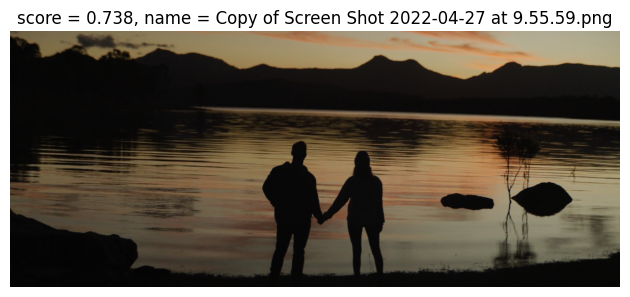

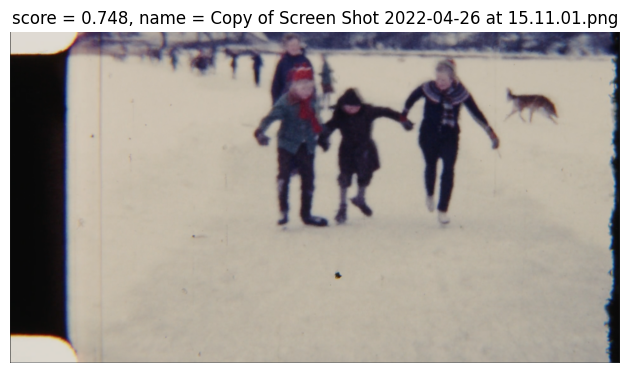

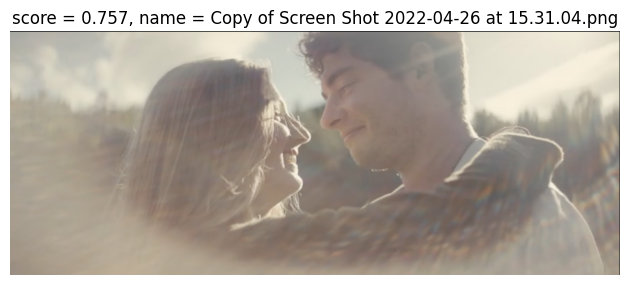

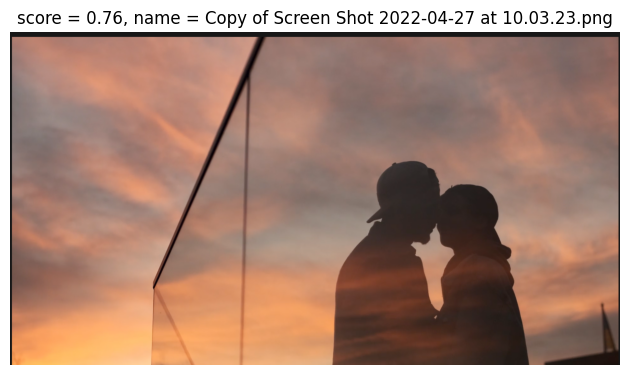

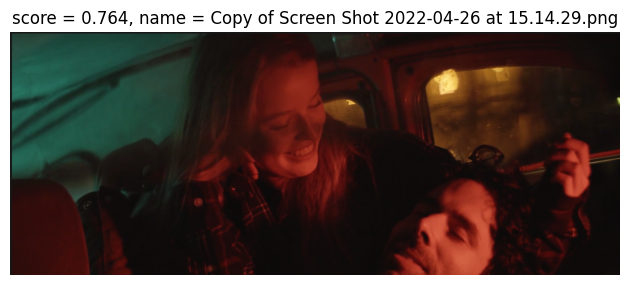

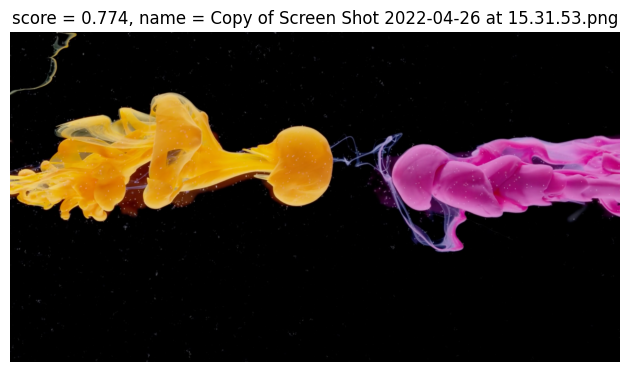

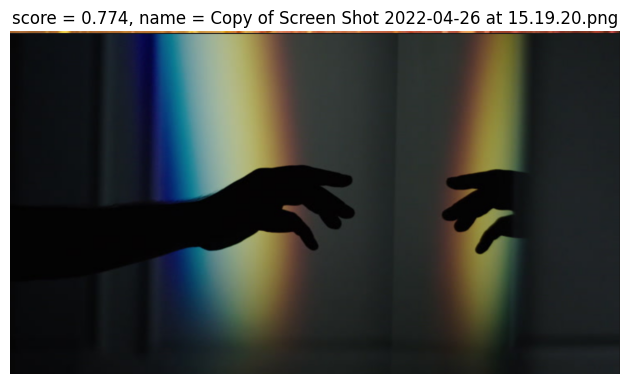

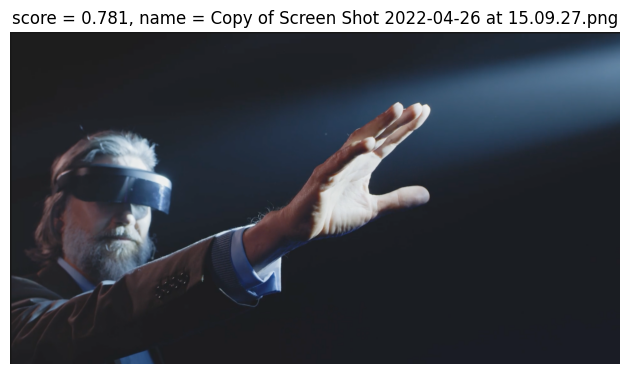

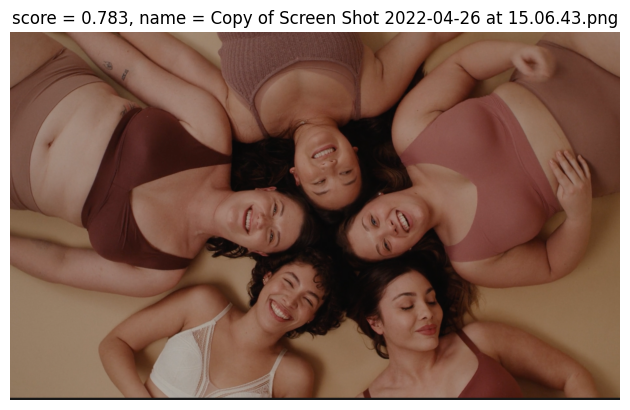

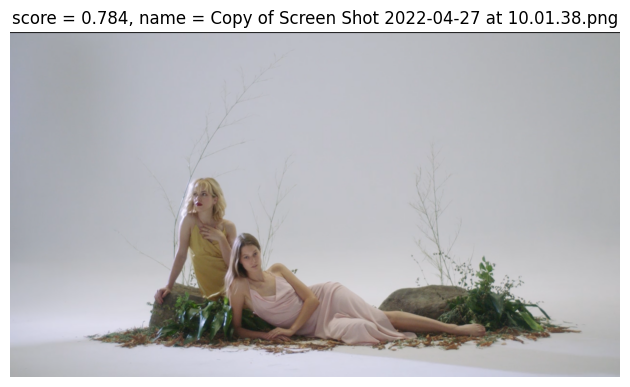

In [15]:
query_text = 'happy people holding hands'
utils.get_query_results_in_figs(chromdb_instance, query_text, 10)

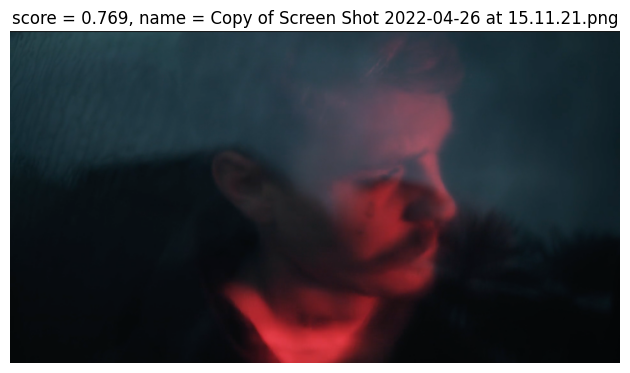

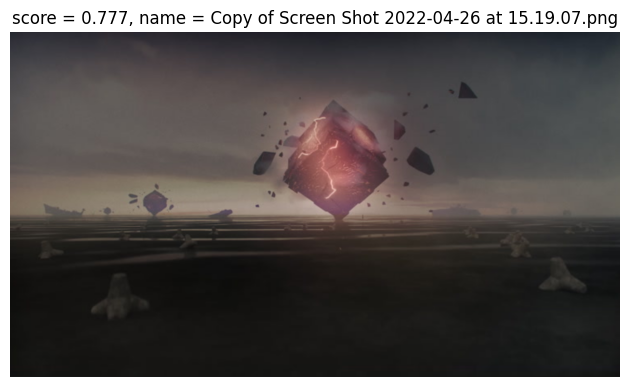

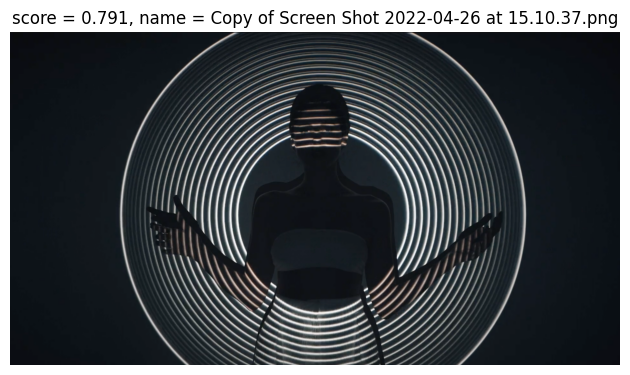

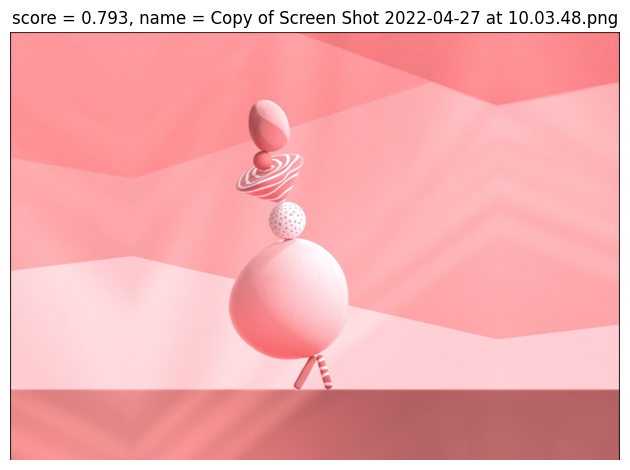

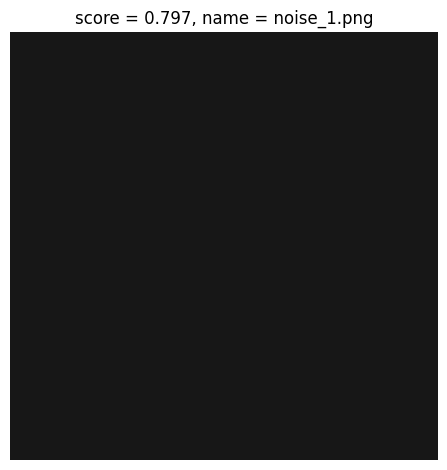

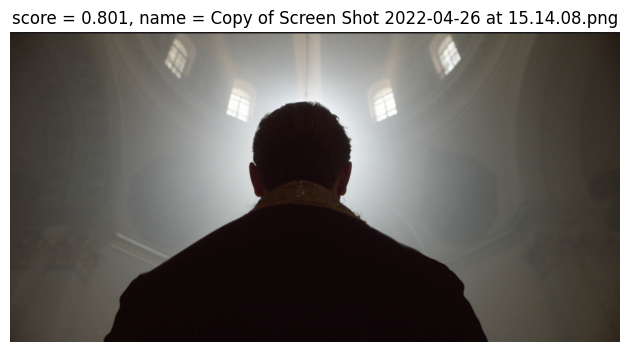

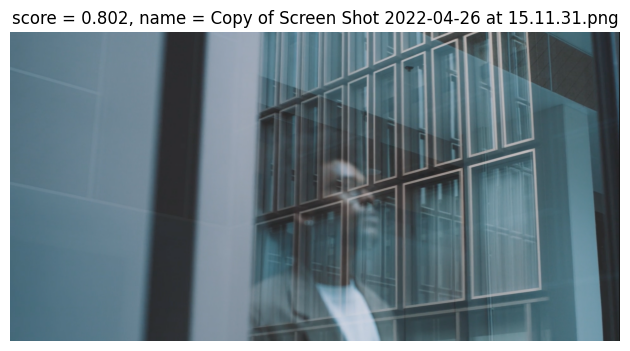

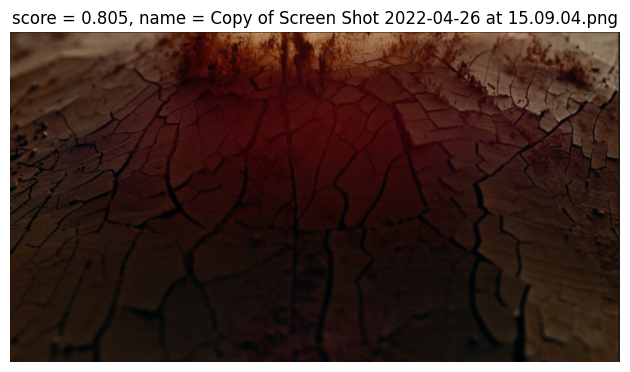

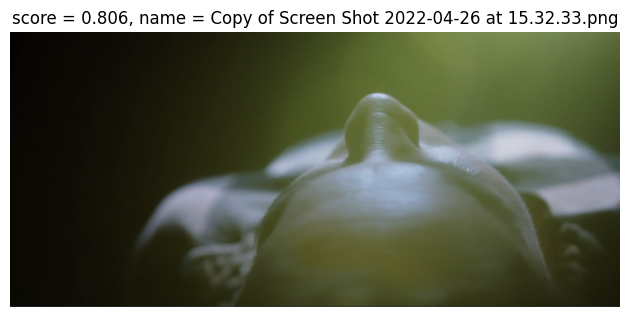

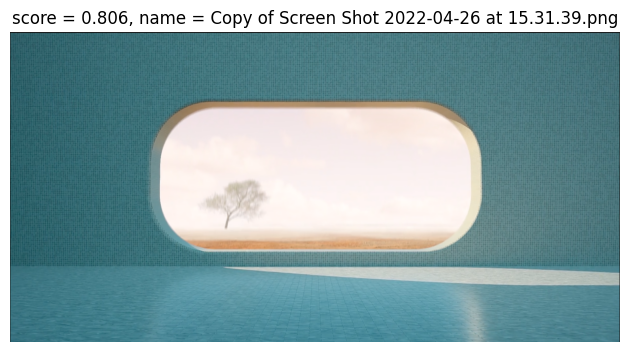

In [17]:
query_text = 'soldier on a tank '
utils.get_query_results_in_figs(chromdb_instance, query_text, 10)

### Some important notes: 
I chose to use cosine similarity as the distance metric because it is effective for measuring similarity in terms of semantic meaning for several reasons:

1. Normalization: Long texts and short texts can have different lengths but similar meanings, so magnitude is not a reliable indicator of similarity.
2.	Effective in High-Dimensional Spaces: Cosine similarity works well in high-dimensional spaces and does not suffer from the curse of dimensionality.
3.	Empirical Evidence: Cosine similarity has proven to be a reliable measure for semantic similarity.

### Why i chose to use ChromaDB?
- Mainly due to ease of use - low overhead for making it work, and user friendly

I look at this task as a POC, If we were looking for higher performance vector database, I would choose diffrently - scaNN/ Qdrant.

### General considerations: 
- open source
- cloud ? 
- ease of integration 
- performace 


## Part 3 - Evaluate

Based on what you've built already - how will you evaluate the quality?
This section can have a code answer, text answer or both.


1.	Human Evaluation Process:
- Select a group of participants to perform predefined queries.
- For each query, participants will review the top 10 results and rate them based on relevance.
- Calculate the average relevance score for each query based on participant ratings.
- Pros and Cons:
	-	Pros: Provides high-quality feedback due to human judgment.
	- Cons: The process is subjective, time-consuming, and costly.
	-  Measure with precision at k 

2. Taking insiration from this  [Using LLM-as-a-judge](https://huggingface.co/learn/cookbook/en/llm_judge) , we can use LLM(GPT4o) as a judge. We can do the following, feed the GPT4 with the query and the k first results, and ask it to rate the relevance. This will help save const since it dont require humans in the loop. Also for future use we can keep this data, and later on, train a smaller model on this data set.
4. Prepare a test data set, queries with expected results. The dataset will need to be made by human annotators.
5. Robustness to noise. In the data set, we can put (as you did :) ) some noisy images, and see how often they appear in the top x results.

## Code implementation -  Noise robustness
- I have notice that that there are two "noise" images. 
- I remame it to noise_1 and noise_2.
- The test: For a given set of queries, run the search and count how often the noise images appear in the top K results. This will be done for each query and for each value of K, ranging from 1 to 10. Also i will use two set of queries, this queries have the same semantic meaning, but one is concise and the other is more eloborated. 

### what am i trying to do?
- Test the noise robustness of the search engine. 
- See if for the more elborated the queries the noise is reduce.

The queries:

In [11]:
test_queries_short = [
        "sunset over mountains",
        "people together with hands up",
        "colorful stripes",
        "city skyline at night",
        "forest with fog",
    ]
test_queries_long = [

        "A beautiful sunset casting a warm glow over a range of majestic mountains, with the sky painted in shades of orange and pink.",
        "A group of joyful people gathered together, raising their hands in celebration, capturing a moment of unity and excitement.",
        "A vivid display of colorful stripes arranged in a harmonious pattern, showcasing a spectrum of bright and vibrant hues.",
        "A stunning view of a city skyline illuminated by the lights of skyscrapers and buildings against the dark night sky, reflecting on the calm water below.",
        "A serene forest shrouded in a mystical fog, with tall trees barely visible through the mist, creating an ethereal and tranquil atmosphere.",
]

Get the noise frequency, per query, per K.

In [12]:
noise_robustness_short = utils.get_noise_apperance_frequecy_per_n_to_show(
    chromdb_instance,
    test_queries_short,
    'noise',
    [1,2,3,4,5,6,7,8,9,10]
     )
    
noise_robustness_long = utils.get_noise_apperance_frequecy_per_n_to_show(
    chromdb_instance,
    test_queries_long,
    'noise',
    [1,2,3,4,5,6,7,8,9,10]
     )

In the figure below, the x-axis represents the number of recommendations shown to the user, and the y-axis indicates the noise frequency - the rate of noise images in queries - (queries with noise image)/(all queries) . We have two plots: one for short queries and another for long queries.

For short queries, the noise frequency increases with the number of recommendations.

For long queries, the noise frequency also increases with the number of recommendations but plateaus at K = 4.

Key Insights:

- The more recommendations shown, the higher the noise frequency. This is intuitive because more recommendations result in looser relevance.
- Using more elaborate queries reduces the noise.
- Our current system is not robust to noise. Users may encounter irrelevant recommendations even in the top 2 results if they use concise queries.
- A potential way to reduce noise is to enhance user queries by using a mechanism, such as an LLM ,to enrich the queries by asking it to elborate them.

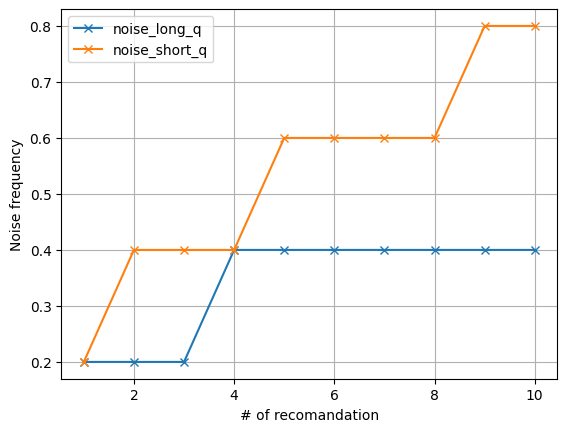

In [13]:
df_short = pd.DataFrame.from_dict(noise_robustness_short, orient='index' ).rename(columns={0:'noise_short_q'})
df_long = pd.DataFrame.from_dict(noise_robustness_long, orient='index').rename(columns={0:'noise_long_q'})

(
    df_long
    .join(df_short)
    .plot(style = 'x-')

)
plt.xlabel('# of recomandation')
plt.ylabel('Noise frequency')
plt.grid()

The end! 
That was fun :) 